In [2]:
# load model
# https://github.com/ContextualAI/gritlm
from gritlm import GritLM
model = GritLM("GritLM/GritLM-7B", torch_dtype="auto", mode="embedding")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Created GritLM: torch.bfloat16 dtype, mean pool, embedding mode, bbcc attn


In [3]:
# embedding test
from scipy.spatial.distance import cosine
def get_similarity(embedding1, embedding2):
    return 1 - cosine(embedding1, embedding2)

texts = ["machine learning", "deep learning"]
results = model.encode(texts)
similarity = get_similarity(results[0], results[1])
print(results.shape, similarity)

(2, 4096) 0.9033003987849012


In [14]:
# load text
# files = ["text1_atari200.txt", "text2_shakespear", "text3_wikipedia.txt"]
files = ["text1_atari200.txt"]
text = ""
for file in files:
    with open(f'texts/{file}', "r") as f:
        text += f.read()
text = text.replace("\n", " ")
len(text), text[:100]

(28052,
 'Human-level Atari 200x faster Steven Kapturowski1 , Víctor Campos*1, Ray Jiang*1, Nemanja Rakićević1')

In [15]:
# split text into sentences
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
parts = sent_tokenize(text)
len(parts), parts[:2]

[nltk_data] Downloading package punkt to /home/tobias/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


(170,
 ['Human-level Atari 200x faster Steven Kapturowski1 , Víctor Campos*1, Ray Jiang*1, Nemanja Rakićević1 , Hado van Hasselt1 , Charles Blundell1 and Adrià Puigdomènech Badia1 1DeepMind, *Equal contribution The task of building general agents that perform well over a wide range of tasks has been an impor\x02tant goal in reinforcement learning since its inception.',
  'The problem has been subject of research of a large body of work, with performance frequently measured by observing scores over the wide range of environments contained in the Atari 57 benchmark.'])

In [16]:
# generate embedding for all sentences
import numpy as np
from tqdm import tqdm
from dataclasses import dataclass

@dataclass
class Sentence:
    text: str
    embedding: np.ndarray

results = []
for sentence in tqdm(parts):
    embedding = model.encode(sentence)
    results.append(Sentence(sentence, embedding))

results[0].text, results[0].embedding.shape, results[0].embedding

100%|██████████| 170/170 [00:05<00:00, 29.24it/s]


('Human-level Atari 200x faster Steven Kapturowski1 , Víctor Campos*1, Ray Jiang*1, Nemanja Rakićević1 , Hado van Hasselt1 , Charles Blundell1 and Adrià Puigdomènech Badia1 1DeepMind, *Equal contribution The task of building general agents that perform well over a wide range of tasks has been an impor\x02tant goal in reinforcement learning since its inception.',
 (4096,),
 array([-0.02513456, -0.02813485, -0.02770187, ...,  0.01720375,
         0.01365934,  0.00933769], dtype=float32))

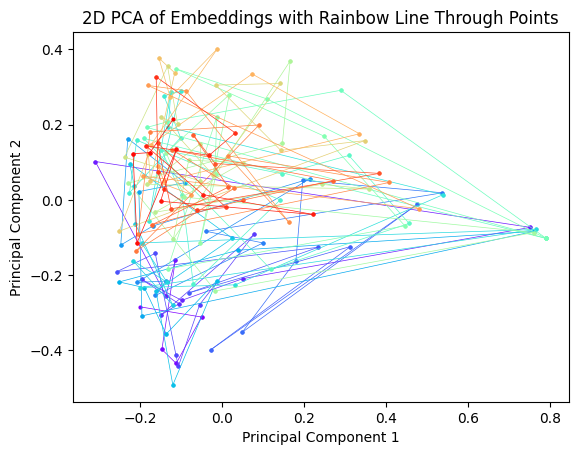

In [17]:
# Visualize
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Assuming embeddings are extracted as shown
embeddings = np.array([sentence.embedding for sentence in results])

# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Generate colors
num_points = reduced_embeddings.shape[0]
colors = cm.rainbow(np.linspace(0, 1, num_points))

fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the points and the line through them in rainbow colors
for i in range(num_points - 1):
    ax.plot(reduced_embeddings[i:i+2, 0], reduced_embeddings[i:i+2, 1], color=colors[i], marker='o', markersize=2,linewidth=0.5)

plt.title('2D PCA of Embeddings with Rainbow Line Through Points')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


In [18]:
# calculate rolling embeddings
class RollingEmbedding:
    def __init__(self):
        self.children:list[Sentence] = []
        self.sentence = None
    
    def add_sentence(self, sentence:Sentence):
        self.children.append(sentence)
        self.update()
    
    def update(self):
        assert len(self.children) > 0
        if len(self.children) == 1:
            self.sentence = self.children[0]
            return

        text = " ".join([sentence.text for sentence in self.children])
        embedding = model.encode(text)
        self.sentence = Sentence(text, embedding)

    def remove_last(self):
        self.children.pop()
        self.update()

    def __repr__(self):
        return f"RollingEmbedding({len(self.children)}, {self.sentence.text}, {self.sentence.embedding})"


rolling_embeddings = []
working = RollingEmbedding()
for sentence in tqdm(results):
    working.add_sentence(sentence)
    if len(working.children) == 1:
        continue

    similarity = get_similarity(working.sentence.embedding, sentence.embedding)
    print(similarity)
    if similarity < 0.5:
        working.remove_last()
        rolling_embeddings.append(working.sentence)
        working = RollingEmbedding()

# add last working
if len(working.children) > 0:
    rolling_embeddings.append(working.sentence)

print()
print(len(rolling_embeddings))

for re in rolling_embeddings:
    print(f"- {re.embedding[:3]}... {re.text}")


  3%|▎         | 5/170 [00:00<00:23,  7.15it/s]

0.6240683980008485
0.7388096451759338
0.7248990699709029
0.593017052771698
0.5421816979538392


  5%|▌         | 9/170 [00:01<00:14, 11.40it/s]

0.6050963872556268
0.10297718644142151
0.9103580117225647
0.7172032257560812


  9%|▉         | 16/170 [00:01<00:08, 18.75it/s]

0.8504514947668167
0.6951293349266052
0.5527437329292297
0.6374243687815779
0.7130214743005363


 11%|█         | 19/170 [00:01<00:08, 18.36it/s]

0.6696511507034302
0.5785378217697144
0.6327279210090637
0.40105434662427664


 15%|█▍        | 25/170 [00:01<00:07, 19.64it/s]

0.583664255847462
0.8991398215293884
0.24810126412518452
0.686254102810974
0.4598317766289852


 19%|█▉        | 33/170 [00:01<00:05, 26.98it/s]

0.9121896300372375
0.6511168687869996
0.746929407119751
0.7106069922447205
0.7374229650921517
0.356835791061176


 24%|██▎       | 40/170 [00:02<00:04, 26.87it/s]

0.9509372769669032
0.7708441751692204
0.5409128665924072
0.6024941385535642
0.6963032122019832


 27%|██▋       | 46/170 [00:02<00:04, 26.33it/s]

0.11624421231483173
0.8544996294081005
0.7507583126651741
0.7282552719116211
0.6816109012597275


 29%|██▉       | 49/170 [00:02<00:05, 21.77it/s]

0.6682923039285038
0.7199339866638184
0.47867801658380216
0.8535067017666518


 31%|███       | 53/170 [00:02<00:04, 24.01it/s]

0.8545981645584106
0.7043086920060566
0.6821382655625012
0.45844178896448806


 35%|███▌      | 60/170 [00:03<00:04, 24.58it/s]

0.16156894404518052
0.581488465159445
0.230442301604611
0.8786774205373196
0.8490209236449282


 39%|███▉      | 67/170 [00:03<00:04, 22.98it/s]

0.723659439305035
0.705420196056366
0.6466819047927856
0.7494346350094472


 41%|████      | 70/170 [00:03<00:04, 21.02it/s]

0.6041811108589172
0.39705642444231726
0.6552909211901108
0.6395510029658977


 46%|████▌     | 78/170 [00:03<00:03, 25.35it/s]

0.5226914313663795
0.3217569589614868
0.9331839561195444
0.6807002830922785
0.07724263749249694


 49%|████▉     | 83/170 [00:04<00:03, 25.94it/s]

0.961748246938206
0.9373736381530762
0.8970710306486799
0.06359538625465
0.9794527900545144


 54%|█████▎    | 91/170 [00:04<00:02, 31.03it/s]

0.8433262203141334
0.42948704537672144
0.9676934749806093
0.6301932775743914
0.4757087514226893
0.8606106299343896


 56%|█████▋    | 96/170 [00:04<00:02, 33.72it/s]

0.5582178997462365
0.6524676084518433
0.5493404865264893
0.15508556365966797
0.7058531641960144
0.40207363342361335


 61%|██████    | 104/170 [00:04<00:02, 25.87it/s]

0.9746196850907632
0.5876835338880748
0.4431520138292313
0.4502858519554138


 65%|██████▍   | 110/170 [00:04<00:01, 32.78it/s]

0.8602601802504185
0.667985836507583
0.62188009154082
0.8766368554018069
0.8318497638791955


 67%|██████▋   | 114/170 [00:05<00:02, 27.59it/s]

0.7169731090648848
0.608966552676765
0.39740089766385867


 72%|███████▏  | 122/170 [00:05<00:01, 26.88it/s]

0.9308103322982788
0.5548096895217896
0.4614745401457234
0.7876244783401489
0.614271539875017


 74%|███████▎  | 125/170 [00:05<00:01, 24.34it/s]

0.7092863744071958
0.7593354130187397
0.7599085795852122
0.5535988807678223


 75%|███████▌  | 128/170 [00:05<00:02, 19.98it/s]

0.6199456310337074
0.4868234395980835
0.7674395123196284
0.6656745867951769
0.647998231410774


 81%|████████  | 137/170 [00:06<00:01, 25.50it/s]

0.723578648353897
0.27922279474803213
0.806523323059082
0.3772529363632202
0.5620364620729084


 84%|████████▎ | 142/170 [00:06<00:01, 26.98it/s]

0.7805384397506714
0.7732995017349437
0.4853446772900041
0.5313244462013245
0.5913734436035156


 89%|████████▉ | 151/170 [00:06<00:00, 30.35it/s]

0.4424317479133606
0.9146332740783691
0.6508088111877441
0.6412295485275726
0.5691631518796904


 91%|█████████ | 155/170 [00:06<00:00, 29.65it/s]

0.3230637504496432
0.710910341468762
0.6291078108017343
0.6119984619618389
0.6881689801014734
0.6500022411346436


 95%|█████████▌| 162/170 [00:06<00:00, 26.07it/s]

0.6808889318042369
0.3899081349372864
0.8825905586061052
0.7050728446332081
0.4627937376499176


100%|██████████| 170/170 [00:07<00:00, 23.77it/s]

0.7091747522354126
0.8594247698783875
0.7511950283530351
0.6194895505905151
0.7339015444458464

31
- [-0.02169167 -0.02453292 -0.03070128]... Human-level Atari 200x faster Steven Kapturowski1 , Víctor Campos*1, Ray Jiang*1, Nemanja Rakićević1 , Hado van Hasselt1 , Charles Blundell1 and Adrià Puigdomènech Badia1 1DeepMind, *Equal contribution The task of building general agents that perform well over a wide range of tasks has been an important goal in reinforcement learning since its inception. The problem has been subject of research of a large body of work, with performance frequently measured by observing scores over the wide range of environments contained in the Atari 57 benchmark. Agent57 was the first agent to surpass the human benchmark on all 57 games, but this came at the cost of poor data-efficiency, requiring nearly 80 billion frames of experience to achieve. Taking Agent57 as a starting point, we employ a diverse set of strategies to achieve a 200-fold reduction of experi